# IMDB sentiment analysis

This notebook contains an approach to address the task of predicting scores from the famous IMDB movie review dataset. Usually, this dataset is exploited for simple positive/negative sentiment analysis and it has been shown that great results can be obtained by using simple features, like `BoW` (e.g. with `TF-IDF`). 

Instead, the task of predicting 1 to 10 scores is much more challenging, since, for example, small scale variations in the score value could be due to human arbitrary decisions. Moreover, simple approaches, like the above-mentioned `BoW`, may result in poor classification metrics.

In [104]:
import os
import re
import sys
import tarfile
import urllib.request
from functools import partial

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.sentiment.util import mark_negation
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.metrics import (
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    plot_confusion_matrix,
    r2_score,
)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [46]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
RANDOM_SEED = 42

## Data loading

In [9]:
# Set the dataset name and URL
dataset_name = "imdb"
dataset_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Create the dataset folder
dataset_folder = os.path.join(os.getcwd(), "datasets", dataset_name)
original_dataset_folder = os.path.join(dataset_folder, "original")
if not os.path.exists(original_dataset_folder):
    os.makedirs(original_dataset_folder)

# Create the dataframe folder
df_folder = os.path.join(dataset_folder, "dataframe")
if not os.path.exists(df_folder):
    os.makedirs(df_folder)
dataframe_path = os.path.join(df_folder, dataset_name + ".pkl")

In [7]:
# Download and extract the dataset
original_dataset_path = os.path.join(original_dataset_folder, "movies.tar.gz")
if not os.path.exists(original_dataset_path):
    urllib.request.urlretrieve(dataset_url, original_dataset_path)
    print("Successful download")
    tar = tarfile.open(original_dataset_path)
    tar.extractall(original_dataset_folder)
    extracted_folder_name = tar.getnames()[0]
    tar.close()
    print("Successful extraction")
else:
    print("Dataset already downloaded and extracted")

Dataset already downloaded and extracted


In [8]:
if not os.path.exists(dataframe_path):
    dataframe_rows = []
    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            folder = os.path.join(original_dataset_folder, "aclImdb", split, sentiment)
            for filename in os.listdir(folder):
                file_path = os.path.join(folder, filename)
                try:
                    if os.path.isfile(file_path):
                        with open(file_path, mode="r", encoding="utf-8") as text_file:
                            # Extract info
                            text = text_file.read()
                            score = filename.split("_")[1].split(".")[0]
                            file_id = filename.split("_")[0]

                            # Compute sentiment
                            num_sentiment = (
                                1 if sentiment == "pos"
                                else 0 if sentiment == "neg"
                                else -1
                            )

                            # Create single dataframe row
                            dataframe_row = {
                                "file_id": file_id,
                                "score": score,
                                "sentiment": num_sentiment,
                                "split": split,
                                "text": text,
                            }
                            dataframe_rows.append(dataframe_row)
                except Exception as e:
                    print("Failed to process %s. Reason: %s" % (file_path, e))
                    sys.exit(0)

    # Transform the list of rows in a proper dataframe
    dataframe = pd.DataFrame(dataframe_rows)
    dataframe_cols = ["file_id", "score", "sentiment", "split", "text"]
    dataframe = dataframe[dataframe_cols]
    dataframe.to_pickle(dataframe_path)
else:
    print("Dataframe already saved as a pickle file")

Dataframe already saved as a pickle file


In [119]:
df = pd.read_pickle(dataframe_path)
df["score"] = pd.to_numeric(df["score"])
df.head()

,file_id,score,sentiment,split,text
0,2257,7,1,train,"Sarafina was a fun movie, and some of the song..."
1,4778,9,1,train,"Like his early masterpiece ""The Elephant Man"" ..."
2,7284,8,1,train,When I was young I had seen very few movies. M...
3,4845,9,1,train,Hello Playmates.I recently watched this film f...
4,6822,7,1,train,"""Opening Night"" released in 1977, tries to be ..."


## Data exploration

Below we can see that the number of examples in classes 1 and 10 is much higher than the number of examples in the other classes. This means that most probably our classification results will be skewed towards very high or very low classes. This aspect is also reinforced by the inherent difficulty of the task, i.e. it is easy to discriminate between positive and negative reviews, while it may be very difficult to obtain a good estimate of the exact score number.

In [11]:
print("Distribution of scores: ")
df["score"].value_counts()

Distribution of scores: 


1     10122
10     9731
8      5859
4      5331
3      4961
7      4803
9      4607
2      4586
Name: score, dtype: int64

In [12]:
score_labels = sorted(df["score"].unique())
print(f"Score labels: {score_labels}")

Score labels: [1, 2, 3, 4, 7, 8, 9, 10]


Something which may be worth considering is that some reviews are present multiple times in the dataset. The strange thing is that we don't observe real duplicates (since rows are unique), but we can see that some texts are present more than once in the dataset.

In theory, this could get us in trouble with some estimators, like naive Bayes, which assumes i.i.d. samples.

In [59]:
num_dup_texts = df["text"].duplicated().value_counts()[True]
print(f"Number of duplicated texts: {num_dup_texts}")
print(
    f"Number of duplicated rows: {num_dup_texts - df.drop_duplicates()['text'].duplicated().value_counts()[True]}"
)

Number of duplicated texts: 418
Number of duplicated rows: 0


To check how duplicates are formed, we group them by the `text` column and aggregate values of other columns present in different rows of the same group. In particular, we use a `frozenset` aggregation, in order to have an hashable iterable structure. 

In [93]:
dup_texts = (
    df[df["text"].duplicated(keep=False)]
    .groupby("text")
    .agg(
        {
            "file_id": frozenset,
            "score": frozenset,
            "sentiment": frozenset,
            "split": frozenset,
        }
    )
)
dup_texts.head()

,file_id,score,sentiment,split
text,,,,
"""Go Fish"" garnered Rose Troche rightly or wrongly the reputation of a film maker with much promise.<br /><br />Its then hard to understand how she could turn out a movie made up of stereotypes that one associates with inferior sitcoms. The entire film rings hollow. I cringed the whole way through.<br /><br />Its supposed to be a look into nineties human sexuality. Well not much more here to be learned than from ""In and Out"". By now most of us actually do know, that there are men who are sexually attracted to women and there men who are sexually attracted to men and there are even men sexually attracted to both sexes. <br /><br />Seldom has this revelation been portrayed on the screen with so little wit and style.<br /><br />Pathetic.","(2183, 10977)",(2),(0),(test)
"""Three"" is a seriously dumb shipwreck movie. Masquerading as a psychological thriller, it's closest relative is the monumentally superior ""Dead Calm"" (also featuring Billy Zane). ""Dead Calm"" provided well drawn characters to root for in the form of Sam Neil and Nicole Kidman's grieving parents attempting to re-define their relationship on an ocean cruise. They end up being terrorised by Zane's adrift psycho-killer. It provided sharp, increasingly ratcheted suspense, a scary feeling of claustrophobia in open seas as the cat and mouse game of life and death unfolded.<br /><br />""Three"" suffers from poorly drawn characterisation (the audience doesn't care what happens to any of them), a stupid and unnecessary voodoo plot device, a total lack of suspense or excitement and some thudding, hammy performances from the principal players. Zane in particular goes way over the top in an irritatingly mannered fashion. In ""Dead Calm"" he was menacing, wired and seething with barely controlled sexual violence. Here he is bombastic, petulant slimy, and unravelled. And where does he get his seemingly inexhaustible supply of dry cigarettes and cigars? And how come his lighter stays full of juice for over a year? Ms Brook is very picturesque, stunningly pretty, but both her chest and rear appear to have been wildly over-inflated by some sort of life-raft pump. They do, however, succeed in acting with more skill and conviction than the rest of her. Dramatic actress, in the purest sense of the term, she is not. The guy playing the voodoo-hexed Manuel, the third component of this sorry triangle, could have been replaced by a lump of driftwood - no one would notice. In fact, judging by his complete lack of ability to deliver dialogue in any meaningful or dynamic way, driftwood represents a potential improvement in the casting stakes (excuse pun).<br /><br />Plus sides: the scenery is nice and the cinematography (above and below the water) is credible.<br /><br />I'm guessing this had a very limited (if any) theatrical release or went straight to rental and retail DVD. The reason for this is it's not very good. If you want something decent along these lines, get ""Dead Calm."" It was made by people who knew a bit about cinema.","(6089, 4129)",(3),(0),(test)
"""Witchery"" might just be the most incoherent and lamentably scripted horror movie of the 80's but, luckily enough, it has a few compensating qualities like fantastic gore effects, an exhilarating musical score and some terrific casting choices. Honestly the screenplay doesn't make one iota of sense, but who cares when Linda Blair (with an exploded hairstyle) portrays yet another girl possessed by evil powers and David Hasselhof depicts a hunky photographer (who can't seem to get laid) in a movie that constantly features bloody voodoo, sewn-shut lips, upside down crucifixions, vicious burnings and an overused but genuinely creepy tune. Eight random people are gathered together on an abandoned vacation resort island off the coast of Massachusetts. The young couple is there to investigate the place's dark history; the dysfunctional family (with a pregnant Linda Blair even though nob

We might want to check the dataframe to see if these duplicates are actually present.. and indeed they are.

In [128]:
df.loc[df["file_id"] == "12298"]

,file_id,score,sentiment,split,text
3178,12298,8,1,train,After Garbo's introduction to sound in Clarenc...
18717,12298,4,0,train,"""Witchery"" might just be the most incoherent a..."
27359,12298,9,1,test,"When Melville's ""Pierre; or The Ambiguities"" h..."
42806,12298,2,0,test,"Unfortunately, this movie is absolutely terrib..."


In [126]:
df.loc[df["file_id"] == "69"]

,file_id,score,sentiment,split,text
3366,69,10,1,train,I was up late flipping cable channels one nigh...
24624,69,4,0,train,"I thought this was a very clunky, uninvolving ..."
28426,69,10,1,test,i found the story to be just enough of a thril...
49642,69,4,0,test,"""Witchery"" might just be the most incoherent a..."


In [127]:
df.iloc[18717] == df.iloc[49642]

file_id      False
score         True
sentiment     True
split        False
text          True
dtype: bool

In [129]:
df.loc[df["file_id"] == "4129"]

,file_id,score,sentiment,split,text
10125,4129,10,1,train,"It's a cooking competition show, Americanized...."
18566,4129,1,0,train,After watching about half of this I was ready ...
31341,4129,8,1,test,The movie has taken a little flack for playing...
43466,4129,3,0,test,"""Three"" is a seriously dumb shipwreck movie. M..."


In [130]:
df.loc[df["file_id"] == "6089"]

,file_id,score,sentiment,split,text
1502,6089,10,1,train,"OK, I overrated it just a bit to offset at lea..."
23892,6089,4,0,train,"I like movies about UFOs, which is why I recen..."
26522,6089,10,1,test,TEP is like a long cool drink of water after c...
43736,6089,3,0,test,"""Three"" is a seriously dumb shipwreck movie. M..."


In [131]:
df.iloc[43466] == df.iloc[43736]

file_id      False
score         True
sentiment     True
split         True
text          True
dtype: bool

We can observe that duplicated texts are $\dots$
- $\dots$ not due to the sentiment column
- $\dots$ not so much related to scores (just few duplicated examples have different score values)
- $\dots$ given by the same text being in the train and test split (which could lead to better prediction accuracy not reflecting the truth)
- $\dots$ given by the same file being repeated with a different `file_id`

In [96]:
dup_texts.drop("file_id", axis=1).apply(lambda x: x.value_counts()).T.stack()

score      (1)              143.0
           (3)               57.0
           (10)              54.0
           (2)               48.0
           (4)               47.0
           (9)               20.0
           (8)               17.0
           (7)               16.0
           (10, 7)            1.0
           (3, 4)             1.0
           (8, 7)             1.0
           (8, 10)            1.0
sentiment  (1)              110.0
           (0)              296.0
split      (test)           191.0
           (train)           92.0
           (test, train)    123.0
dtype: float64

So, we can drop those duplicates so as to get less skewed estimates at prediction time.

In [102]:
df = df.drop(df[df["text"].duplicated()].index)

Let's check if there are reviews with a low number of characters, which could be removed from the dataset, since they shouldn't bring too much information.

Since there are only a handful of small reviews, we will keep them.

In [118]:
sentences = df["text"]
sentences[sentences.str.len() <= 50]

37688    I hope this group of film-makers never re-unites.
47910            What a script, what a story, what a mess!
49540                     Read the book, forget the movie!
Name: text, dtype: object

To continue with data exploration, we wish to check for the words which have the highest frequency in the dataset, after a certain probability mass (to avoid corpus-specific stopwords).

In [7]:
def compute_freqs(words, top, thresh):
    """
    Return the `top` most frequent words of the dataset,
    after filtering them to be after `thresh` frequency 
    """
    fdist = nltk.FreqDist(words)
    common = {
        k: fdist.freq(k)
        for k, _ in sorted(fdist.items(), key=lambda i: i[1], reverse=True)
    }
    words = list(common.keys())
    freqs = list(common.values())
    common_cumulative = {k: sum(freqs[:i]) for i, k in enumerate(words)}
    return [k for k, v in common_cumulative.items() if v >= thresh][:top]


def print_df_freqs(dataframe, top=10, thresh=0.7):
    """
    Print the `top` most frequent words of the dataset,
    for each class
    """
    for c in score_labels:
        words = []
        text = df.query(f"score == {c}")["text"].to_numpy()
        for t in text:
            words.extend(word_tokenize(t.lower()))
        print(f"Number of different words in class {c}: {len(set(words))}")
        common = compute_freqs(words, top=top, thresh=thresh)
        print(f"{top} most frequent (after {thresh} frequency) words in class {c}:")
        print(common)
        print()


print_df_freqs(df)

Number of different words in class 1: 61170
10 most frequent (after 0.7 frequency) words in class 1:
['book', 'maybe', 'gets', 'almost', 'may', '2', 'sure', 'since', 'however', '..']

Number of different words in class 2: 44293
10 most frequent (after 0.7 frequency) words in class 2:
['rather', 'own', 'budget', 'sense', 'actor', 'both', 'feel', 'yet', 'having', 'half']

Number of different words in class 3: 49303
10 most frequent (after 0.7 frequency) words in class 3:
['screen', 'audience', 'stupid', 'family', 'actor', 'house', 'rest', 'sex', 'once', 'during']

Number of different words in class 4: 52665
10 most frequent (after 0.7 frequency) words in class 4:
['actor', 'death', 'different', 'help', 'fan', 'together', 'takes', 'each', 'less', 'house']

Number of different words in class 7: 50749
10 most frequent (after 0.7 frequency) words in class 7:
['\x96', 'until', 'second', 'believe', 'keep', 'kids', 'become', 'small', 'hollywood', 'production']

Number of different words in clas

Now, let's see how much we can improve the quality of the dataset by using some ad-hoc regular expressions. In particular, we can observe that decimal numbers and HTML tags are present in a lot of examples.

In [14]:
def re_match(regex, text):
    """
    Return True if the given regex matches inside the given text,
    otherwise return False
    """
    return re.match(regex, text) is not None


# Find dates
DATE_RE = r"\d{1,2}[-\/\.]\d{1,2}[-\/\.]\d{2,4}"
num_dates = df["text"].map(partial(re_match, DATE_RE)).value_counts()
print("Number of texts with dates:")
print(num_dates)
print()

# Find floats
FLOAT_RE = r"(\d*\,)?\d+.\d*"
num_floats = df["text"].map(partial(re_match, FLOAT_RE)).value_counts()
print("Number of texts with decimal numbers:")
print(num_floats)
print()

# Find ints
INT_RE = r"(?<=\s)\d+(?=\s)"
num_ints = df["text"].map(partial(re_match, INT_RE)).value_counts()
print("Number of texts with integers:")
print(num_ints)
print()

# Find brackets
BRACKETS_RE = r"\[[^]]*\]"
num_brackets = df["text"].map(partial(re_match, BRACKETS_RE)).value_counts()
print("Number of texts with elements in square brackets:")
print(num_brackets)
print()

# Find HTML tags
HTML_RE = r"<.*?>"
num_html = df["text"].map(partial(re_match, HTML_RE)).value_counts()
print("Number of texts with HTML tags:")
print(num_html)
print()

# Find punctuation
PUNCTUATION_RE = r"[^\w{w}\s\{<>}]+"

Number of texts with dates:
False    49997
True         3
Name: text, dtype: int64

Number of texts with decimal numbers:
False    49814
True       186
Name: text, dtype: int64

Number of texts with integers:
False    50000
Name: text, dtype: int64

Number of texts with elements in square brackets:
False    49987
True        13
Name: text, dtype: int64

Number of texts with HTML tags:
False    49846
True       154
Name: text, dtype: int64



## Train/test utils

In this section we are splitting the input data by the `split` attribute, which is provided by the dataset makers and is used to split training and testing data in half. Moreover, some utility functions are defined below.

In [15]:
train_df = df.loc[df['split'] == "train"]
test_df = df.loc[df['split'] == "test"]

In [17]:
train_corpus, train_scores, test_corpus, test_scores = (
    train_df["text"].tolist(),
    np.array(train_df["score"].tolist()),
    test_df["text"].tolist(),
    np.array(test_df["score"].tolist()),
)
print(f"Number of sentences in the training set: {len(train_corpus)}")
print(f"Number of sentences in the test set: {len(test_corpus)}")

Number of sentences in the training set: 25000
Number of sentences in the test set: 25000


In [23]:
def predict(classifier, x_train, x_test):
    """
    Given a classifier and training/testing matrices, return predictions
    """
    return (classifier.predict(x_train), classifier.predict(x_test))

In [32]:
def print_evaluation(test_scores, pred_test_scores):
    """
    Given ground-truth test scores and predicted test scores,
    print classification measures
    """
    # Evaluation as a regression task
    print("R2 score %f" % (r2_score(test_scores, pred_test_scores)))
    print("MAE %f" % (mean_absolute_error(test_scores, pred_test_scores)))
    print("MSE %f" % (mean_squared_error(test_scores, pred_test_scores)))
    print()

    # Evaluation as a multi-class classification task
    report = classification_report(
        test_scores, np.around(pred_test_scores), labels=score_labels
    )
    print(report)

    # Fancy confusion matrix
    plot_confusion_matrix(
        classifier,
        test_corpus,
        test_scores,
        normalize="true",
        cmap=plt.cm.Blues,
        values_format=".2f",
    )

## Preprocessing

The following block of code simply shows the english stopwords that will be used to filter out high-frequency words from the corpora.

In [20]:
EN_STOPWORDS = set(stopwords.words("english"))
print(f"Stopwords ({len(EN_STOPWORDS)}): {EN_STOPWORDS}")

Stopwords (179): {'it', 'down', 'he', "isn't", 'than', 'you', "wouldn't", 'until', 'o', "weren't", 'whom', "mightn't", 'doing', 'each', 'because', 'been', "don't", 'these', 'was', "shouldn't", 'their', 'y', "hadn't", 'd', "it's", 'very', 'mustn', "mustn't", 'with', 'themselves', 'that', 'here', 'yourself', 'aren', 'be', "you'll", 'again', "needn't", 'ain', 'how', 'any', 'were', 'we', 'under', 'our', "didn't", 'will', "should've", 'don', 'wouldn', 'him', 'when', 'her', 'same', 'there', "you're", 'has', 'being', "that'll", 'some', 've', 'only', 'haven', "doesn't", 'does', 'hasn', "haven't", 't', "you'd", 'what', 'to', 'out', 'is', 'once', 'through', 's', 'this', 'having', 'or', 'too', 'won', 'did', 'hers', "aren't", 'not', 'them', 'should', 'which', 'more', 'about', 'where', 'herself', 'at', 'isn', 'just', 'mightn', "you've", 'i', 'no', 'itself', 'theirs', 'couldn', 'a', 'during', 'off', 'then', 'why', "couldn't", 'by', 'from', 'after', 'himself', 'its', 'll', 'she', 'are', 'am', 'had', 

The `preprocess_text` function is highly customizable and can be tested with different kinds of parameter combinations, in order to achieve the best results with problem at hand.

In particular, extensive testing shows the following:
- Stemming/lemmatization does not alter prediction performance at all
- Marking negative meaning of words with the `_NEG` token actually gives worse results than the baseline approach, that may be due to the much higher input space w.r.t. the one in which words are considered as-is
- Removing punctuation and stopwords does not seem to have a big impact on classification measures
- Removing words with less than `n` characters is pretty much the same as removing stopwords

In [26]:
STEMMER = nltk.porter.PorterStemmer()
LEMMATIZER = nltk.wordnet.WordNetLemmatizer()


def stem_text(text):
    return [STEMMER.stem(word) for word in text]


def lemmatize_text(text):
    return [LEMMATIZER.lemmatize(word) for word in text]


def preprocess_text(
    text,
    mark_neg=False,
    remove_punct=False,
    remove_stopwords=False,
    min_chars=None,
    root=None,
):
    # Strip trailing spaces and remove newlines
    text = text.strip().replace("\n", " ").replace("\r", " ")
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(HTML_RE, "", text)
    # Remove text in square brackets
    text = re.sub(BRACKETS_RE, "", text)
    # Remove dates
    text = re.sub(DATE_RE, "", text)
    # Remove floating numbers
    text = re.sub(FLOAT_RE, "", text)
    # Mark negation
    if mark_neg:
        text = " ".join(mark_negation(text.split(), double_neg_flip=False))
        EN_STOPWORDS.add("_NEG")
    # Remove punctuation
    if remove_punct:
        text = re.sub(PUNCTUATION_RE, "", text)
    # Leave single whitespace
    text = text.split()
    # Remove words with less than `n` chars
    if min_chars is not None and isinstance(min_chars, int):
        text = [word for word in text if len(word) >= min_chars]
    # Remove stopwords
    if remove_stopwords:
        text = [word for word in text if word not in EN_STOPWORDS]
    # Perform stemming/lemmatization
    if root == "stem":
        text = stem_text(text)
    elif root == "lemmatize":
        text = lemmatize_text(text)
    # Return the text as a string
    return " ".join(text)

In the cell below we are storing a number of different partially applied functions that can be used as a parameter for the optimization algorithms available in `scikit-learn`. In particular, in the following sections we will use this list of functions as the `preprocessor` key of the `CountVectorizer` and/or `TfidfVectorizer`, which will then be optimized by grid search.

In [ ]:
preprocessing_funcs = [
    partial(
        preprocess_text,
        remove_punct=False,
        remove_stopwords=False,
        min_chars=2,
        root=None,
    ),
    partial(
        preprocess_text,
        remove_punct=True,
        remove_stopwords=True,
        min_chars=2,
        root=None,
    ),
    partial(
        preprocess_text,
        remove_punct=True,
        remove_stopwords=True,
        min_chars=3,
        root="lemmatize",
    ),
]

To show an example of how the preprocessing step works, we are displaying a random sentence before and after the `preprocess_text` function is called.

In [27]:
rnd_text = np.random.choice(df.index, 1)[0]
print(f"Random text with score {df['score'].iloc[rnd_text]}")
print()
print(f"Before pre-processing:")
print(df['text'].iloc[rnd_text])
print()
print("After pre-processing:")
print(preprocess_text(df['text'].iloc[rnd_text]))

Random text with score 8

Before pre-processing:
For a film that got little publicity, and few people have heard about, this was pretty good. It's another one of these modern-day British crime films that are quirky ("Snatch," "Sexy Beast," etc.). It's not wild like "Snatch" but it's interesting and it has some rough characters.<br /><br />It also has a corny and somewhat predictable ending but early in the show - not late - has some neat twists to make it very interesting for the first-time viewer. Basically, it's about a low-key British male who sends away for a Russian "mail order bride" who winds up, with the aid of two Russian male friends, providing a couple of big surprises.<br /><br />Ben Chapin and Nicole Kidman co-star, and are very good as are Vincent Cassel and Matthieu Kassovitz as Kidman's Russian cohorts. This is a different kind of film and well-acted. Kidman once again proves she's far more than just a beautiful face.

After pre-processing:
for a film that got little pu

## Baseline

The baseline approach is simply the one which could be used for sentiment prediction (positive/negative), i.e. a `TF-IDF` vectorizer which uses unigrams and a logistic regression estimator.

In [28]:
pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)),
    ]
)
classifier = pipeline.fit(train_corpus, train_scores)

R2 score 0.484319
MAE 1.468520
MSE 6.284040

              precision    recall  f1-score   support

           1       0.53      0.84      0.65      5022
           2       0.21      0.05      0.08      2302
           3       0.27      0.12      0.17      2541
           4       0.32      0.34      0.33      2635
           7       0.32      0.24      0.27      2307
           8       0.27      0.25      0.26      2850
           9       0.23      0.04      0.06      2344
          10       0.49      0.77      0.59      4999

    accuracy                           0.43     25000
   macro avg       0.33      0.33      0.30     25000
weighted avg       0.37      0.43      0.37     25000



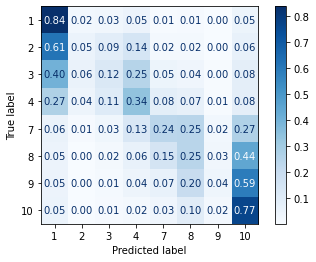

In [33]:
pred_train_scores, pred_test_scores = predict(classifier, train_corpus, test_corpus)
print_evaluation(test_scores, pred_test_scores)

## Classification with logistic regression

In this section we have to achieve the best result we can with the logistic regression estimator. So, we can play with the vectorizer and the preprocessing function, to try and boost classification metrics.

In [40]:
pipeline = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                ngram_range=(1, 2),
                preprocessor=preprocess_text,
                min_df=0.01,
                max_df=0.7,
            ),
        ),
        ("tfidf", TfidfTransformer(sublinear_tf=True)),
        ("clf", LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)),
    ]
)

parameters = {
    "vect__preprocessor": preprocessing_funcs,
    "vect__ngram_range": [(1, 1), (1, 2)],
    # "vect__min_df": np.linspace(0, 0.1, 3),
    # "vect__max_df": np.linspace(0.7, 0.9, 3),
    "tfidf__use_idf": (True, False),
}
searcher = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=1,
)
print(f"Parameter grid: {searcher.param_grid}")
classifier = searcher.fit(train_corpus, train_scores)
print(f"Best parameters: {searcher.best_params_}")

Parameter grid: {'vect__preprocessor': [functools.partial(<function preprocess_text at 0x7fd7f3528dc0>, remove_punct=False, remove_stopwords=False, min_chars=2, root=None), functools.partial(<function preprocess_text at 0x7fd7f3528dc0>, remove_punct=True, remove_stopwords=True, min_chars=2, root=None), functools.partial(<function preprocess_text at 0x7fd7f3528dc0>, remove_punct=True, remove_stopwords=True, min_chars=3, root='lemmatize')], 'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False)}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.8min finished


Best parameters: {'tfidf__use_idf': True, 'vect__ngram_range': (1, 2), 'vect__preprocessor': functools.partial(<function preprocess_text at 0x7fd7f3528dc0>, remove_punct=False, remove_stopwords=False, min_chars=2, root=None)}


R2 score 0.506588
MAE 1.434200
MSE 6.012680

              precision    recall  f1-score   support

           1       0.54      0.79      0.64      5022
           2       0.21      0.08      0.12      2302
           3       0.27      0.15      0.19      2541
           4       0.32      0.31      0.32      2635
           7       0.30      0.27      0.28      2307
           8       0.28      0.25      0.26      2850
           9       0.21      0.07      0.10      2344
          10       0.50      0.74      0.60      4999

    accuracy                           0.42     25000
   macro avg       0.33      0.33      0.31     25000
weighted avg       0.37      0.42      0.38     25000



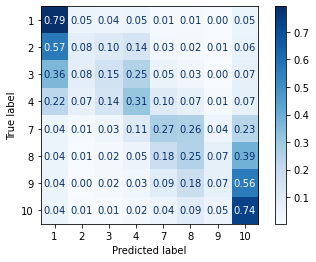

In [41]:
pred_train_scores, pred_test_scores = predict(classifier, train_corpus, test_corpus)
print_evaluation(test_scores, pred_test_scores)

## Classification with another classifier

In this section we are not anymore limited to the usage of logistic regression as a model, but we can tweak both the vectorizer and the estimator, in order to possibily get even better results.

In [109]:
def print_results(model):
    print(model.best_params_)
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [108]:
features = [
    ("vect", CountVectorizer(ngram_range=(1, 2), preprocessor=preprocessing_funcs[0])),
    ("tfidf", TfidfTransformer(sublinear_tf=True, use_idf=True)),
]
features_params = {
    "vect__max_df": np.linspace(0.7, 0.9, 3),
    "vect__min_df": np.linspace(0, 0.1, 3),
}

In [110]:
# Define different models
model_labels = [
    "dt",
    "nb",
    "lp",
    "svc",
]

# Set the parameters by cross-validation
dt_parameters = [dict(features_params, **{"clf__max_depth": range(1, 20)})]
nb_parameters = [
    dict(
        features_params,
        **{
            "clf__var_smoothing": [
                10,
                1,
                1e-1,
                1e-2,
                1e-3,
                1e-4,
                1e-5,
                1e-6,
                1e-07,
                1e-8,
                1e-9,
                1e-10,
            ]
        }
    )
]
lp_parameters = [dict(features_params, **{"clf__early_stopping": [True]})]
svc_parameters = [
    dict(
        features_params,
        **{
            "clf__kernel": ["rbf"],
            "clf__gamma": [1e-3, 1e-4],
            "clf__C": [1, 10, 100, 1000],
        }
    ),
    dict(features_params, **{"clf__kernel": ["linear"], "clf__C": [1, 10, 100, 1000]}),
]

# Define a dictionary with an entry for each model to try
models = {
    "dt": {
        "name": "Decision Tree",
        "estimator": DecisionTreeClassifier(),
        "params": dt_parameters,
    },
    "nb": {
        "name": "Gaussian Naive Bayes",
        "estimator": GaussianNB(),
        "params": nb_parameters,
    },
    "lp": {
        "name": "Linear Perceptron",
        "estimator": Perceptron(),
        "params": lp_parameters,
    },
    "svc": {
        "name": "Support Vector Classifier",
        "estimator": SVC(),
        "params": svc_parameters,
    },
}

# Scores to evaluate grid search on
scores = ["f1_macro", "r2"]

Fitting 5 folds for each of 171 candidates, totalling 855 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 85.3min
[Parallel(n_jobs=-1)]: Done 855 out of 855 | elapsed: 100.7min finished



{'clf__max_depth': 19, 'vect__max_df': 0.7, 'vect__min_df': 0.0}
0.086 (+/-0.004) for {'clf__max_depth': 1, 'vect__max_df': 0.7, 'vect__min_df': 0.0}
0.085 (+/-0.006) for {'clf__max_depth': 1, 'vect__max_df': 0.7, 'vect__min_df': 0.05}
0.091 (+/-0.002) for {'clf__max_depth': 1, 'vect__max_df': 0.7, 'vect__min_df': 0.1}
0.086 (+/-0.004) for {'clf__max_depth': 1, 'vect__max_df': 0.8, 'vect__min_df': 0.0}
0.085 (+/-0.005) for {'clf__max_depth': 1, 'vect__max_df': 0.8, 'vect__min_df': 0.05}
0.091 (+/-0.002) for {'clf__max_depth': 1, 'vect__max_df': 0.8, 'vect__min_df': 0.1}
0.086 (+/-0.004) for {'clf__max_depth': 1, 'vect__max_df': 0.9, 'vect__min_df': 0.0}
0.085 (+/-0.006) for {'clf__max_depth': 1, 'vect__max_df': 0.9, 'vect__min_df': 0.05}
0.091 (+/-0.002) for {'clf__max_depth': 1, 'vect__max_df': 0.9, 'vect__min_df': 0.1}
0.103 (+/-0.004) for {'clf__max_depth': 2, 'vect__max_df': 0.7, 'vect__min_df': 0.0}
0.103 (+/-0.004) for {'clf__max_depth': 2, 'vect__max_df': 0.7, 'vect__min_df': 0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 22.8min finished


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

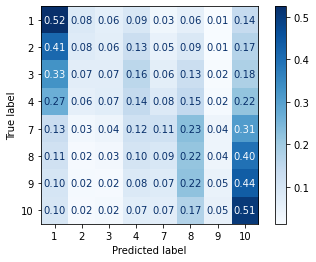

In [112]:
for score in scores:
    best_scores = {}
    for model in models.values():
        pipeline = Pipeline(features + [("clf", model["estimator"])])
        searcher = GridSearchCV(
            estimator=pipeline,
            param_grid=model["params"],
            scoring=score,
            n_jobs=-1,
            cv=5,
            return_train_score=True,
            verbose=1,
        )
        classifier = searcher.fit(train_corpus, train_scores)
        print()
        print_results(searcher)
        print()
        pred_train_scores, pred_test_scores = predict(
            classifier, train_corpus, test_corpus
        )
        print_evaluation(test_scores, pred_test_scores)
        best_scores[model["name"]] = searcher.best_score_

    for name, best_score in best_scores.items():
        print(f"{name} -> {score}: {best_score}")